## Setup

In [75]:
import os
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Sanction Analysis") \
    .getOrCreate()

## Geospatial Analysis of Sanctions Impact

/tmp/ipykernel_822319/2389560373.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Counts', fontsize=12, title_fontsize=14)


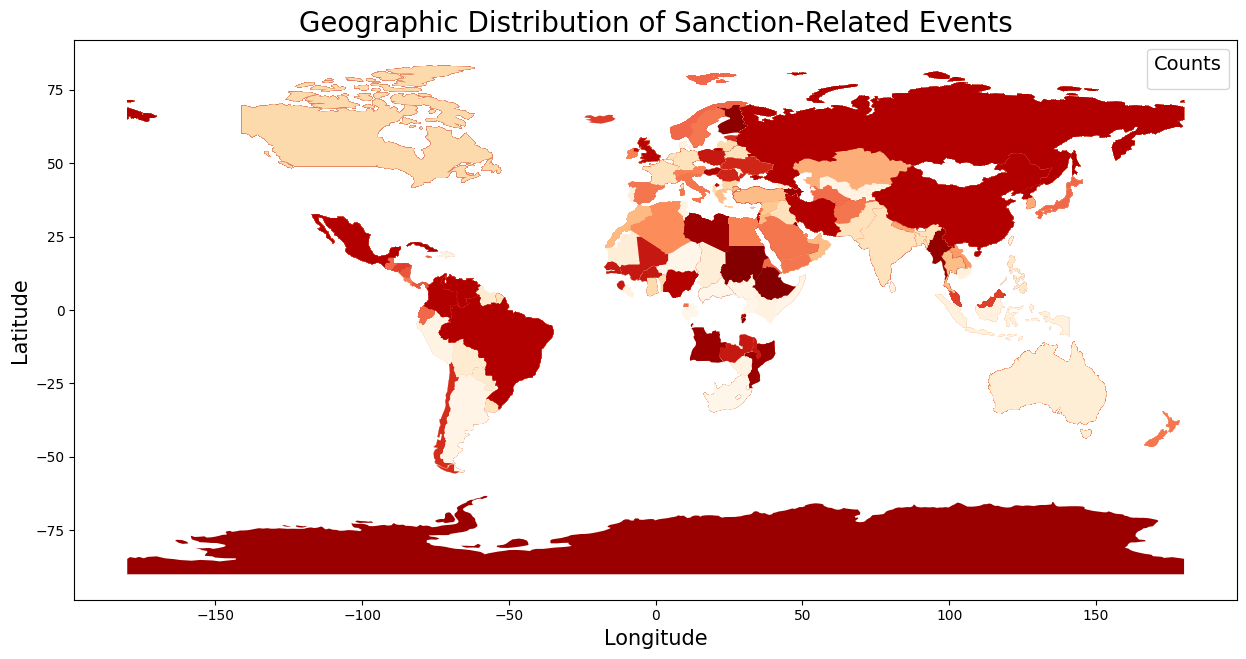

In [79]:
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row
from shapely.wkt import dumps
from pyspark.sql.types import StructType, StructField, StringType
from fuzzywuzzy import fuzz

# Function to parse and expand locations
def parse_and_expand_locations(row):
    locations = row.LOCATIONS.split(';')
    rows = []
    for loc in locations:
        components = loc.split('#')
        new_row = Row(
            DATE=row.DATE,
            NUMARTS=row.NUMARTS,
            PERSONS=row.PERSONS,
            ORGANIZATIONS=row.ORGANIZATIONS,
            SOURCEURLS=row.SOURCEURLS,
            COUNTS=row.COUNTS,
            location_name=components[1],
            country_code=components[2],
            ADM1_code=components[3]
        )
        rows.append(new_row)

    return rows

# Create a Spark session
spark = SparkSession.builder \
    .appName("Sanction Analysis") \
    .getOrCreate()

directory = "/home/tiago/factored-datathon-2024-seed42/files"

gkg_files = glob.glob(directory + '/**/*gkg.csv', recursive=True)
csv_files = [file for file in gkg_files if file.lower().endswith('.csv')]

# Read the CSV files into a single DataFrame
df = spark.read.option("header", "true").option("sep", "\t").csv(csv_files)

# Read shapefile for world map
world = gpd.read_file("/home/tiago/factored-datathon-2024-seed42/notebooks/ne_110m_admin_0_countries.shp")

# Convert the geometry column to WKT format
world['geometry_wkt'] = world['geometry'].apply(dumps)

# Drop the original geometry column
world = world.drop(columns=['geometry'])

# Ensure relevant columns are included
# Assuming 'ADMIN' is the column with country names
world = world[['ADMIN', 'geometry_wkt']]

# Define the schema for the GeoDataFrame
schema = StructType([
    StructField("ADMIN", StringType(), True),
    StructField("geometry_wkt", StringType(), True)
])

# Convert the GeoDataFrame to a Spark DataFrame
world_spark = spark.createDataFrame(world)

# Filter the dataframe to include only the sanction-related events
sanction_events = df.filter(df.THEMES.contains('SANCTIONS'))

# Use flatMap to expand and transform the DataFrame
expanded_df = sanction_events.rdd.flatMap(parse_and_expand_locations).toDF()

sanction_events_geo = world_spark.join(expanded_df, world_spark.ADMIN == expanded_df.location_name, 'inner')

# Convert back to GeoDataFrame if needed for plotting
sanction_events_geo_pandas = sanction_events_geo.toPandas()
sanction_events_geo_gpd = gpd.GeoDataFrame(sanction_events_geo_pandas, geometry=gpd.GeoSeries.from_wkt(sanction_events_geo_pandas['geometry_wkt']))

# Set the figure size
plt.figure(figsize=(15, 10))

# Plot the geographic distribution of sanction-related events
sanction_events_geo_gpd.plot(column='COUNTS', cmap='OrRd', legend=True, ax=plt.gca())

# Set the title and labels for the plot
plt.title('Geographic Distribution of Sanction-Related Events', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)

# Adjust the legend
plt.legend(title='Counts', fontsize=12, title_fontsize=14)

# Show the plot
plt.show()